In [2]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from bs4 import MarkupResemblesLocatorWarning
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter
import gradio as gr
from urllib.parse import urlparse, parse_qs
import requests
from urllib.parse import urlparse
import socket
import streamlit as st

In [3]:
df = pd.read_csv("/home/samarth/ML_Models/Malicious_Webpage/Webpages_Classification_train_data.csv", nrows = 10000)
print(df.shape)
print(df.columns)
print(df.head())

(10000, 12)
Index(['Unnamed: 0', 'url', 'url_len', 'ip_add', 'geo_loc', 'tld', 'who_is',
       'https', 'js_len', 'js_obf_len', 'content', 'label'],
      dtype='object')
   Unnamed: 0                                       url  url_len  \
0           0  http://members.tripod.com/russiastation/       40   
1           1          http://www.ddj.com/cpp/184403822       32   
2           2                  http://www.naef-usa.com/       24   
3           3                     http://www.ff-b2b.de/       21   
4           4       http://us.imdb.com/title/tt0176269/       35   

          ip_add        geo_loc  tld      who_is https  js_len  js_obf_len  \
0  42.77.221.155         Taiwan  com    complete   yes    58.0         0.0   
1  3.211.202.180  United States  com    complete   yes    52.5         0.0   
2   24.232.54.41      Argentina  com    complete   yes   103.5         0.0   
3   147.22.38.45  United States   de  incomplete    no   720.0       532.8   
4  205.30.239.85  United Stat

In [10]:
df['https'] = df['https'].map({'yes':1,'no':0})
df['who_is'] = df['who_is'].map({'complete':1,'incomplete':0})
df['label'] = df['label'].map({'good':1,'bad':0})

In [11]:
df['content']= df['content'].fillna('')
df['word_count'] = df['content'].apply(lambda x: len(x.split()))
suspecious_keywords = ['password','login','verify','click', 'porn', 'adult', 'bank', 'account', 'confirm', 'alert']
df['suspecious_words'] = df['content'].apply(lambda x: sum(1 for word in suspecious_keywords if word in x.lower()))

warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)

def count_tags(html, tag):
    try:
        if not isinstance(html, str) or html.strip() == "":
            return 0
        soup = BeautifulSoup(html, "html.parser")
        return len(soup.find_all(tag))
    except:
        return 0
df['script_tags'] = df['content'].apply(lambda x: count_tags(x, 'script'))
df['form_tags'] = df['content'].apply(lambda x: count_tags(x, 'form'))
df['iframe_tags'] = df['content'].apply(lambda x: count_tags(x, 'iframe'))

In [12]:
features = ['url_len', 'https', 'who_is', 'js_len', 'js_obf_len', 'word_count', 
            'suspecious_words', 'script_tags', 'form_tags', 'iframe_tags']

df['https'] = df['https'].map({'yes': 1, 'no': 0})
df['who_is'] = df['who_is'].map({'complete': 1, 'incomplete': 0})
df['https'] = df['https'].fillna(0)
df['who_is'] = df['who_is'].fillna(0)


X = df[features]
y = df['label']



In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [14]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [15]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9980


In [16]:
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        48
           1       1.00      1.00      1.00      1952

    accuracy                           1.00      2000
   macro avg       1.00      0.96      0.98      2000
weighted avg       1.00      1.00      1.00      2000



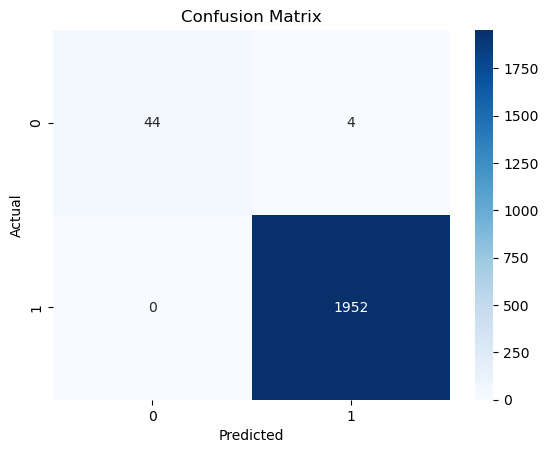

In [17]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [18]:
df['label'].value_counts()
smote = SMOTE(random_state=42)

In [19]:
X_numeric = X.select_dtypes(include='number')

X_resampled, y_resampled = smote.fit_resample(X_numeric, y)


print("Resampled dataset shape:", Counter(y_resampled))


Resampled dataset shape: Counter({1: 9760, 0: 9760})


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)


model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.998719262295082

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1952
           1       1.00      1.00      1.00      1952

    accuracy                           1.00      3904
   macro avg       1.00      1.00      1.00      3904
weighted avg       1.00      1.00      1.00      3904



In [21]:
joblib.dump(model, 'malicious_webpage_detector.pkl')


['malicious_webpage_detector.pkl']

In [22]:
loaded_model = joblib.load('malicious_webpage_detector.pkl')


In [23]:
def extract_features_from_url(url):
    features = []

    features.append(len(url))

    parsed = urlparse(url)
    features.append(1 if parsed.scheme == 'https' else 0)

    try:
        domain = parsed.netloc
        socket.gethostbyname(domain)
        features.append(1)
    except:
        features.append(0)

    try:
        response = requests.get(url, timeout=5)
        soup = BeautifulSoup(response.text, 'html.parser')

        js_code = ''.join(script.get_text() for script in soup.find_all('script'))
        features.append(len(js_code))

        obf_pattern = re.compile(r'(\\x[0-9a-fA-F]+|\\u[0-9a-fA-F]{4}|eval\(|unescape\()')
        obfuscated_parts = obf_pattern.findall(js_code)
        features.append(len(''.join(obfuscated_parts)))

        texts = soup.stripped_strings
        word_count = sum(len(t.split()) for t in texts)
        features.append(word_count)

        suspicious_words = ['login', 'verify', 'account', 'password', 'update', 'secure']
        count = sum(1 for word in suspicious_words if word in response.text.lower())
        features.append(count)

        features.append(len(soup.find_all('script')))

        features.append(len(soup.find_all('form')))

        features.append(len(soup.find_all('iframe')))

    except Exception as e:
        features += [0] * 7

    return features



def predict_from_url(url):
    try:
        features = extract_features_from_url(url)
        prediction = model.predict([features])[0]
        return "🔴 Malicious" if prediction == 1 else "🟢 Safe"
    except Exception as e:
        return f"Error: {str(e)}"

iface = gr.Interface(
    fn=predict_from_url,
    inputs=gr.Textbox(label="Enter URL"),
    outputs=gr.Label(label="Prediction"),
    title="Malicious Webpage Detector",
    description="Enter a URL to check if it's likely to be malicious or safe."
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [24]:
test_df = pd.read_csv('/home/samarth/ML_Models/Malicious_Webpage/Webpages_Classification_test_data.csv')
test_df.head()

,Unnamed: 0,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,content,label
0,0,http://www.dutchthewiz.com/freeware/,36,175.67.214.68,China,com,complete,yes,38.5,0.0,"Decay suggest in 1315.. Current constitution, ...",good
1,1,http://www.collectiblejewels.com,32,188.120.171.121,Sweden,com,incomplete,yes,187.0,0.0,breast addict nudger whash ky darkie catholics...,good
2,2,http://www.deadlinedata.com,27,193.51.170.1,France,com,complete,yes,31.0,0.0,Nato's military stoic philosophy says to accep...,good
3,3,http://www.mil.fi/maavoimat/kalustoesittely/00...,56,13.237.35.44,Australia,fi,complete,yes,152.0,0.0,Night being newton. according to the formation...,good
4,4,http://www.avclub.com/content/node/24539,40,220.193.62.89,China,com,complete,yes,150.0,0.0,34 per two children. if we exercise simple pra...,good


In [25]:
# test_df = pd.read_csv("Webpages_Classification_test_data.csv")

label_mapping = {'good': 1, 'bad': 0}
test_df['label'] = test_df['label'].map(label_mapping)

test_df['https'] = test_df['https'].map({'yes': 1, 'no': 0})
test_df['who_is'] = test_df['who_is'].map({'complete': 1, 'incomplete': 0})

test_df['content'] = test_df['content'].fillna('')

test_df['word_count'] = test_df['content'].apply(lambda x: len(x.split()))

suspicious_keywords = ['password','login','verify','click', 'porn', 'adult', 'bank', 'account', 'confirm', 'alert']
test_df['suspecious_words'] = test_df['content'].apply(
    lambda x: sum(1 for word in suspicious_keywords if word in x.lower())
)

def count_tags(html, tag):
    try:
        soup = BeautifulSoup(html, "html.parser")
        return len(soup.find_all(tag))
    except:
        return 0

test_df['script_tags'] = test_df['content'].apply(lambda x: count_tags(x, 'script'))
test_df['form_tags'] = test_df['content'].apply(lambda x: count_tags(x, 'form'))
test_df['iframe_tags'] = test_df['content'].apply(lambda x: count_tags(x, 'iframe'))

selected_features = [
    'url_len', 'https', 'who_is', 'js_len', 'js_obf_len',
    'word_count', 'suspecious_words', 'script_tags', 'form_tags', 'iframe_tags'
]
X_test_new = test_df[selected_features]
y_test_new = test_df['label']

model = joblib.load("malicious_webpage_detector.pkl")

y_pred = model.predict(X_test_new)

print("✅ Accuracy:", accuracy_score(y_test_new, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test_new, y_pred))
print("🧮 Confusion Matrix:\n", confusion_matrix(y_test_new, y_pred))


✅ Accuracy: 0.9979554283377632

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.96      8062
           1       1.00      1.00      1.00    353872

    accuracy                           1.00    361934
   macro avg       0.96      0.99      0.98    361934
weighted avg       1.00      1.00      1.00    361934

🧮 Confusion Matrix:
 [[  7939    123]
 [   617 353255]]


In [26]:
model = joblib.load("malicious_webpage_detector.pkl")

# Feature extraction function (you’ll write this)
def extract_features_from_url(url):
    # Dummy example, you'll need actual feature logic here
    return pd.DataFrame([{
        "url_len": len(url),
        "https": 1 if url.startswith("https") else 0,
        # add other features...
    }])

# Streamlit UI
st.title("🔒 Malicious Webpage Detector")

url_input = st.text_input("Enter a URL to check if it's safe:")

if st.button("Analyze"):
    features = extract_features_from_url(url_input)
    prediction = model.predict(features)[0]
    label = "🟢 Safe" if prediction == 0 else "🔴 Malicious"
    st.markdown(f"## Result: {label}")


2025-04-07 00:21:58.929 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-07 00:21:58.932 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-07 00:21:58.935 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-07 00:21:58.936 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-07 00:21:58.938 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-07 00:21:58.939 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-07 00:21:58.941 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-07 00:21:58.932 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [27]:
feature_names = list(X_train.columns)
joblib.dump(feature_names, "feature_names.pkl")


['feature_names.pkl']